# Machine Translation


In [1]:
import collections
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import re
from d2l.tensorflow.data import Vocab, batch_iter

## Read and Pre-process Data

In [2]:
fname = '../data/fra-eng.zip'
with zipfile.ZipFile(fname, 'r') as f:
    raw_text = f.read('fra.txt').decode("utf-8")
print(raw_text[0:262])

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)
Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)


In [3]:
def preprocess_raw(text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    expr = 'CC\-BY 2\.0 \(France\) Attribution: tatoeba\.org #[\d]+ \([\w]+\) & #[\d]+ \([\w]+\)'
    text = re.sub(expr, '', text)
    out = ''
    for i, char in enumerate(text.lower()):
        if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
            out += ' '
        out += char
    return out

text = preprocess_raw(raw_text)
print(text[0:95])

go .	va !	
hi .	salut !	
hi .	salut .	
run !	cours !	
run !	courez !	
who?	qui ?	
wow !	ça alor


## Tokenization


In [4]:
num_examples = 50000
source, target = [], []
for i, line in enumerate(text.split('\n')):
    if i > num_examples:
        break
    parts = line.strip().split('\t')
    if len(parts) == 2:
        source.append(parts[0].split(' '))
        target.append(parts[1].split(' '))

source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['hi', '.']],
 [['va', '!'], ['salut', '!'], ['salut', '.']])

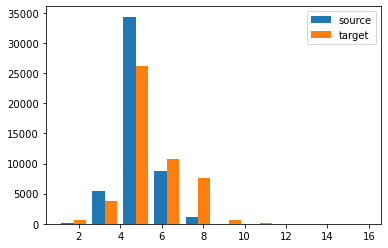

In [5]:
plt.hist([[len(l) for l in source], [len(l) for l in target]],
             label=['source', 'target'])
plt.legend(loc='upper right');

## Vocabulary

In [6]:
def build_vocab(tokens):
    tokens = [token for line in tokens for token in line]
    return Vocab(tokens, min_freq=3, use_special_tokens=True)

src_vocab = build_vocab(source)
len(src_vocab)

3750

## Load Dataset

In [7]:
def pad(line, max_len, padding_token):
    if len(line) > max_len:
        return line[:max_len]
    return line + [padding_token] * (max_len - len(line))

pad(src_vocab[source[0]], 10, src_vocab.pad)

[36, 4, 0, 0, 0, 0, 0, 0, 0, 0]

Convert a list of sentences into an `(num_example, max_len)` index array. 

In [8]:
def build_array(lines, vocab, max_len, is_source):
    lines = [vocab[line] for line in lines]
    if not is_source:
        lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
    array = np.array([pad(line, max_len, vocab.pad) for line in lines])
    valid_len = (array != vocab.pad).sum(axis=1)
    return array, valid_len

Construct data iterators to read data batches.

In [9]:
def load_data_nmt(batch_size, max_len):  # This function is saved in d2l.
    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
    src_array, src_valid_len = build_array(source, src_vocab, max_len, True)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, max_len, False)
    train_features = batch_iter(
        src_array, src_valid_len, batch_size, shuffle=False
    )
    train_labels = batch_iter(
        tgt_array, tgt_valid_len, batch_size, shuffle=False
    )
    return src_vocab, tgt_vocab, train_features, train_labels

In [10]:
src_vocab, tgt_vocab, train_features, train_labels = load_data_nmt(batch_size=2, max_len=8)
for X, X_valid_len in train_features:
    print('X =', X, '\nValid lengths for X =', X_valid_len)
    break

for Y, Y_valid_len in train_labels:
    print('Y =', Y, '\nValid lengths for Y =', Y_valid_len)
    break

X = tf.Tensor(
[[  36    4    0    0    0    0    0    0]
 [1409    4    0    0    0    0    0    0]], shape=(2, 8), dtype=int64) 
Valid lengths for X = tf.Tensor([2 2], shape=(2,), dtype=int64)
Y = tf.Tensor(
[[   1   99   13    2    0    0    0    0]
 [   1 1317   13    2    0    0    0    0]], shape=(2, 8), dtype=int64) 
Valid lengths for Y = tf.Tensor([4 4], shape=(2,), dtype=int64)
